In [1]:
import optuna
import requests

import numpy as np
import scipy.stats
import pandas as pd
import seaborn as sns
from datetime import date
import matplotlib.pyplot as plt

from itertools import product
from tqdm.notebook import tqdm
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV


%matplotlib inline

In [2]:
import warnings

warnings.filterwarnings("ignore")

### Если у вас нет в директории, откуда запускается ноутбук файла holiday.pkl или вы не хотите туда его помещать, то необходимо раскоментить ячейки в разделе "Генерация новых признаков", тогда эта же колонка сгенерируется с помощью данных из интернета, pkl файл создан для быстродействия.

__Осмотр данных__

In [3]:
df = pd.read_excel('временной ряд.xlsx', header=None, names=['time', 'production'])

In [4]:
df

,time,production
0,2019-08-02,7
1,2019-08-05,1
2,2019-08-07,3
3,2019-08-08,4
4,2019-08-09,2
...,...,...
820,2022-06-10,3678
821,2022-06-11,342
822,2022-06-12,196
823,2022-06-13,286


In [5]:
# проверим типы данных

df.dtypes

time          datetime64[ns]
production             int64
dtype: object

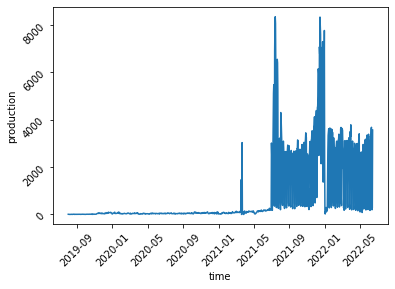

In [6]:
plot = sns.lineplot(x="time", y="production", data=df)

plot.tick_params(rotation=45)

plt.show;

_Обратим внимание, что у нас произошел скачок производства с определенной даты (2021-07), также у нас имеются
два пика раз с периодичностью в полгода, так как у нас стоит задача краткосрочного предсказания, то мы можем
эти данные отбросить. Перед этим подробнее посмотрим на эти данные, чтобы удостовериться в нашем предположении._

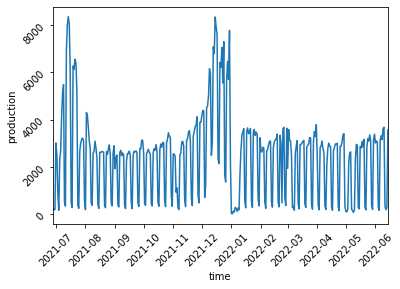

In [7]:
plot = sns.lineplot(x="time", y="production", data=df)

plot.tick_params(rotation=45)
plot.set_xlim([pd.to_datetime('2021-06-28'), pd.to_datetime('2022-06-14')])

plt.show;

_Как видим в предыдущем году резкий скачок производства наблюдался в 2021-07 и 2021-12, продолжался около месяца, делать предсказание, что данный скачок произойдёт повторно в ближайшую неделю я смысла не вижу, поэтому в связи с отсутствием дополнительных данных отбросим эти аномалии и посмотрим на получившийся временной ряд, по которому будем строить модель_

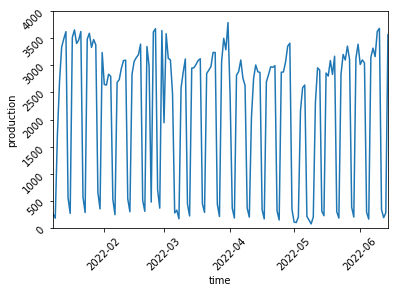

<Figure size 1008x432 with 0 Axes>

In [8]:
plot = sns.lineplot(x="time", y="production", data=df)

plt.figure(figsize=(14, 6))
plot.tick_params(rotation=45)
plot.set_xlim([pd.to_datetime('2022-01-08'), pd.to_datetime('2022-06-14')])
plot.set_ylim([0, 4000])


plt.show;

In [9]:
df.loc[df['time'] == '2022-01-08']

,time,production
667,2022-01-08,264


In [10]:
df_new = df.iloc[667:]

In [11]:
df_new

,time,production
667,2022-01-08,264
668,2022-01-09,186
669,2022-01-10,1716
670,2022-01-11,2698
671,2022-01-12,3333
...,...,...
820,2022-06-10,3678
821,2022-06-11,342
822,2022-06-12,196
823,2022-06-13,286


_Посмотрев подробнее на наше ряд, обнаружим что производство статично с периодом в 7 дней, также данные сходятся с реальным календарём и производство падает в выходные дни._

__Построение базовой модели__

_В связи с этим сделаем базовую модель, которая "предсказывать" данные, беря производительность неделю назад. В качестве метрики качества возьмём MSE и оценим нашу модель на последних 20% датасета. Это будет оценка, которую мы попробуем побить, строя более сложные модели_

In [12]:
df_baseline = df_new.copy()

In [13]:
df_baseline['shift_7'] = df_baseline.production.shift(7)

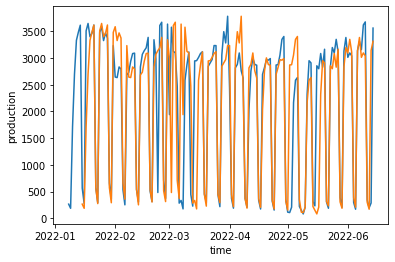

In [14]:
fig, ax = plt.subplots()
ax = sns.lineplot(x='time', y='production', data=df_baseline)
ax1 = sns.lineplot(x='time', y='shift_7', data=df_baseline)

plot.tick_params(rotation=45)
plot.set_xlim([pd.to_datetime('2022-01-08'), pd.to_datetime('2022-06-14')])
plot.set_ylim([0, 4000]);



In [15]:
y_true_base = df_baseline['production'].iloc[int(158 * 0.8):]
y_pred_base = df_baseline['shift_7'].iloc[int(158 * 0.8):]

_MSE = 771717.5625_

In [16]:
mean_squared_error(y_true=y_true_base, y_pred=y_pred_base)

771717.5625

In [17]:
baseline_error = mean_squared_error(y_true=y_true_base, y_pred=y_pred_base)

_Данная модель имеет кучу недостатков, так как она не "ловит" скрытые особенности нашего датасета, попробуем нагенерить кучу фичей и потом отдать это на обучению классическим моделям и постараемся побить результат нашей dummy модели_

__Генерация новых признаков__

In [18]:
df_more_features = df_new.copy()

_Начнём с признаков, которые основаны на данных n предыдущего дня, только на этот раз не будем ограничиваитя только 7-ым днём, а сделаем промежуток 7-30 дней, так как размер нашего сета (158примеров) это позволяет_

In [19]:
for i in range(7, 31):
    df_more_features["lag_{}".format(i)] = df_more_features['production'].shift(i)

_Далее сделаем признаки, соответствующие дням недели, выходным и государственным праздникам РФ в период с 2022-01-08 по 2022-06-14_

In [20]:
df_more_features['weekday'] = df_more_features['time'].dt.dayofweek
df_more_features['is_weekend'] = df_more_features.weekday.isin([5, 6]) * 1

_Для определения государственных праздаников воспользуемся API сайта https://www.isdayoff.ru/ и с помощью цикла пройдёмся по нашим данным, так как загрузка с API требует некоторого времени, то я сделал файл holiday.pkl для ускорения процесса_

In [21]:
# df_more_features['holiday'] = 0

In [22]:
# for i in df_more_features.index:
#     ymd = df_more_features['time'][i].strftime('%Y%m%d')
#     api_respone = requests.get(f"https://isdayoff.ru/{ymd}")
#     if api_respone.text == '0':
#         df_more_features['holiday'][i] = 0
#     else:
#         df_more_features['holiday'][i] = 1
        

In [23]:
# df_more_features.holiday.to_pickle('holiday.pkl')

In [24]:
df_more_features['holiday']= pd.read_pickle('holiday.pkl')

_Здесь можно остановиться, но хотелось бы ещё признаков, для этого воспользуемся оконными функциями и посчитаем статистические параметры в окне за предыдущие 28 дней, хуже ведь вряд ли станет. Окно я взял из расчёта, что для конечных предсказаний мы имели минимум 75% данных, так как при предсказании последней недельной продукции у нас будут отсутствовать данные за предыдущие 6 дней._

In [25]:
df_more_features['max_28'] = df_more_features['production'].rolling(28).max()
df_more_features['mean_28'] = df_more_features['production'].rolling(28).mean()
df_more_features['median_28'] = df_more_features['production'].rolling(28).median()
df_more_features['std_28'] = df_more_features['production'].rolling(28).std()

_Данные колоннки is_weekend и holiday сильно коррелируют, но так как колонка holiday более полная, то уберём is_weekend._

In [26]:
df_more_features = df_more_features.drop(columns='is_weekend')

__Пожалуй на этом с генерацией признаков можно закончить и перейти к построение модели__

_Так как мы использовали признаки, основанные на предыдущих данных, то в некоторых строках у нас имеются пропущенные данные, которые мы просто выкинем, хотя в реальном примере поступать так с 1/6 частью данных конечно не стоит_

In [27]:
y = df_more_features.dropna().production
X = df_more_features.dropna().drop(columns=['time', 'production'])

In [28]:
def timeseries_train_test_split(X, y, test_size):
    """
        Создаём тестовый сплит из последних n строчек
    """

    # строки выбираем по индексу
    test_index = int(len(X) * (1 - test_size))

    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]

    return X_train, X_test, y_train, y_test

In [29]:
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.2)

_Попробуем линейную регрессию из коробки и посмотрим улучшится ли наш результат_

In [30]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [31]:
lr_error = lr.predict(X_test)

_MSE = 227831.996016044_

In [32]:
mean_squared_error(y_true=y_test, y_pred=lr_error)

227831.996016044

_Уже наши предсказания улучшились в 4.5 раза, попробуем применить регуляризациии и кросс-валидации, для этого нам надо предварительно нормализовать наши данные, так как теперь наша модель будет штрафоваться за большие коэффициенты, а изначально у нас продукция измеряется в тысячах, а дни недели в единицах_

In [33]:
scaler = StandardScaler()

In [34]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
tscv = TimeSeriesSplit(n_splits=5)

In [36]:
ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

RidgeCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None))

In [37]:
l2_error = ridge.predict(X_test_scaled)

_MSE = 165385.1700889957_

In [38]:
mean_squared_error(y_true=y_test, y_pred=l2_error)

165385.1700889957

In [39]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

LassoCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None))

In [40]:
l1_error = lasso.predict(X_test_scaled)

_MSE = 111499.77812778637_

In [41]:
mean_squared_error(y_true=y_test, y_pred=l1_error)

111499.77812778637

_Пока что линейная регрессия с LASSO регуляризацией показала лучший результат. Попробуем использовать случайный лес_

In [42]:
rf = RandomForestRegressor(random_state=19)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=19)

In [43]:
rf_error = rf.predict(X_test)

_MSE = 144306.99739615383_

In [44]:
mean_squared_error(y_true=y_test, y_pred=rf_error)

144306.99739615383

_Так как модель, основанная на деревьях решений показала достойный результат, то можно попробовать применить бустинг модели, основанные на деревьях решений, так как они обычно дают лучший результат, чем случайный лес_

In [45]:
LGBM = LGBMRegressor(random_state=19)
LGBM.fit(X_train, y_train)

LGBMRegressor(random_state=19)

In [46]:
LGBM_error = LGBM.predict(X_test)

_MSE = 136521.94162085524_

In [47]:
mean_squared_error(y_true=y_test, y_pred=LGBM_error)

136521.94162085524

_Как видим бустинг из коробки выдал очень хороший результат, особенность модели в том, что она значительно увеличивает качество при оптимизации параметров (возможно, не самая лучшая идея, учитывая размеры нашего датасета)_

In [48]:
def objective(trial):


    param = {
        'metric': 'mean_squared_error', 
        'random_state': 19,
        'n_estimators': 5000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
        'subsample': trial.suggest_float('subsample', 0.2, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
    }

    model = LGBMRegressor(**param)  
    
    model.fit(X_train, y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(X_test)
    pred_labels = np.rint(preds)
    mse = mean_squared_error(y_true=y_test, y_pred=pred_labels)
    return mse

In [49]:
if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=500)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-06-18 13:40:37,263] A new study created in memory with name: no-name-51d94f1d-6a26-415b-b2bd-27be3da0734a
[I 2022-06-18 13:40:47,490] Trial 0 finished with value: 162875.53846153847 and parameters: {'reg_alpha': 0.010484116085174576, 'reg_lambda': 0.008952733044000034, 'colsample_bytree': 0.3773997751433908, 'subsample': 0.8979030176531113, 'learning_rate': 0.01542568992996324, 'max_depth': 4}. Best is trial 0 with value: 162875.53846153847.
[I 2022-06-18 13:40:47,526] Trial 1 finished with value: 143206.38461538462 and parameters: {'reg_alpha': 0.0034302612053961983, 'reg_lambda': 0.015087600778755083, 'colsample_bytree': 0.883354518569379, 'subsample': 0.8995304622507561, 'learning_rate': 0.07513304319653101, 'max_depth': 4}. Best is trial 1 with value: 143206.38461538462.
[I 2022-06-18 13:40:47,556] Trial 2 finished with value: 140165.46153846153 and parameters: {'reg_alpha': 0.003666214736014025, 'reg_lambda': 0.4823301395581927, 'colsample_bytree': 0.5475495051105335, 'sub

[I 2022-06-18 13:40:50,218] Trial 24 finished with value: 131355.88461538462 and parameters: {'reg_alpha': 1.8467702948177502, 'reg_lambda': 1.1424121218364458, 'colsample_bytree': 0.9892968820524953, 'subsample': 0.4872054989838681, 'learning_rate': 0.07889300554841881, 'max_depth': 10}. Best is trial 17 with value: 129287.15384615384.
[I 2022-06-18 13:40:50,256] Trial 25 finished with value: 142895.1923076923 and parameters: {'reg_alpha': 1.5912676214097485, 'reg_lambda': 0.79905180154309, 'colsample_bytree': 0.4435410082976854, 'subsample': 0.5194759093281844, 'learning_rate': 0.09699443407221002, 'max_depth': 10}. Best is trial 17 with value: 129287.15384615384.
[I 2022-06-18 13:40:50,301] Trial 26 finished with value: 133518.26923076922 and parameters: {'reg_alpha': 9.666263779666323, 'reg_lambda': 4.349623914105483, 'colsample_bytree': 0.9203980155419845, 'subsample': 0.433727818571393, 'learning_rate': 0.08298762307702601, 'max_depth': 10}. Best is trial 17 with value: 129287.15

[I 2022-06-18 13:40:52,947] Trial 48 finished with value: 144939.07692307694 and parameters: {'reg_alpha': 0.14104649253635274, 'reg_lambda': 0.001339893326588861, 'colsample_bytree': 0.7484293317137618, 'subsample': 0.20072253469459653, 'learning_rate': 0.053302753219974686, 'max_depth': 4}. Best is trial 42 with value: 127452.0.
[I 2022-06-18 13:40:53,005] Trial 49 finished with value: 134860.92307692306 and parameters: {'reg_alpha': 0.04348848938096238, 'reg_lambda': 0.06837509443402315, 'colsample_bytree': 0.9452090185841313, 'subsample': 0.383590217128183, 'learning_rate': 0.04799224479990028, 'max_depth': 6}. Best is trial 42 with value: 127452.0.
[I 2022-06-18 13:40:53,048] Trial 50 finished with value: 145271.84615384616 and parameters: {'reg_alpha': 0.08768955182188186, 'reg_lambda': 0.9108175835109615, 'colsample_bytree': 0.8742616211844022, 'subsample': 0.2550104680864034, 'learning_rate': 0.0349567095059526, 'max_depth': 8}. Best is trial 42 with value: 127452.0.
[I 2022-06

[I 2022-06-18 13:40:54,609] Trial 72 finished with value: 123714.69230769231 and parameters: {'reg_alpha': 0.7268148548120621, 'reg_lambda': 3.257816456080248, 'colsample_bytree': 0.9553685015810953, 'subsample': 0.30389265029848117, 'learning_rate': 0.07802034224569462, 'max_depth': 7}. Best is trial 57 with value: 117769.19230769231.
[I 2022-06-18 13:40:54,664] Trial 73 finished with value: 127061.42307692308 and parameters: {'reg_alpha': 1.3338840656797681, 'reg_lambda': 3.4733861073800694, 'colsample_bytree': 0.9447630016642392, 'subsample': 0.3210375458338141, 'learning_rate': 0.07922089353991199, 'max_depth': 7}. Best is trial 57 with value: 117769.19230769231.
[I 2022-06-18 13:40:54,716] Trial 74 finished with value: 135141.96153846153 and parameters: {'reg_alpha': 9.798262890914913, 'reg_lambda': 3.342500209184591, 'colsample_bytree': 0.9494917378337534, 'subsample': 0.32869732925418005, 'learning_rate': 0.08150338242180717, 'max_depth': 7}. Best is trial 57 with value: 117769.

[I 2022-06-18 13:41:02,660] Trial 96 finished with value: 135990.65384615384 and parameters: {'reg_alpha': 0.25583204054677566, 'reg_lambda': 7.804314512709315, 'colsample_bytree': 0.9218234475442613, 'subsample': 0.31136237455346816, 'learning_rate': 0.07566193891361449, 'max_depth': 6}. Best is trial 57 with value: 117769.19230769231.
[I 2022-06-18 13:41:02,706] Trial 97 finished with value: 139057.11538461538 and parameters: {'reg_alpha': 0.9686969312726749, 'reg_lambda': 5.647404033035329, 'colsample_bytree': 0.8792597298954425, 'subsample': 0.49995962260932636, 'learning_rate': 0.08242691699773788, 'max_depth': 5}. Best is trial 57 with value: 117769.19230769231.
[I 2022-06-18 13:41:02,758] Trial 98 finished with value: 137883.96153846153 and parameters: {'reg_alpha': 0.6317255791206301, 'reg_lambda': 3.230046082404312, 'colsample_bytree': 0.9030295943414413, 'subsample': 0.41923126065219485, 'learning_rate': 0.07073891208757419, 'max_depth': 6}. Best is trial 57 with value: 11776

[I 2022-06-18 13:41:04,001] Trial 120 finished with value: 131887.26923076922 and parameters: {'reg_alpha': 2.3177143468432324, 'reg_lambda': 5.782470048098885, 'colsample_bytree': 0.9470474223002254, 'subsample': 0.4032868567995135, 'learning_rate': 0.07323403521215169, 'max_depth': 7}. Best is trial 57 with value: 117769.19230769231.
[I 2022-06-18 13:41:04,059] Trial 121 finished with value: 119601.0 and parameters: {'reg_alpha': 0.2219749862912676, 'reg_lambda': 1.9985771834574748, 'colsample_bytree': 0.9865052938127685, 'subsample': 0.3017772859558493, 'learning_rate': 0.05152376477711867, 'max_depth': 8}. Best is trial 57 with value: 117769.19230769231.
[I 2022-06-18 13:41:04,109] Trial 122 finished with value: 123267.0 and parameters: {'reg_alpha': 0.3331924992379716, 'reg_lambda': 1.629034590670463, 'colsample_bytree': 0.9847557178782028, 'subsample': 0.3037369984883194, 'learning_rate': 0.07071822409914412, 'max_depth': 7}. Best is trial 57 with value: 117769.19230769231.
[I 20

[I 2022-06-18 13:41:05,551] Trial 144 finished with value: 127215.03846153847 and parameters: {'reg_alpha': 0.20247268364878898, 'reg_lambda': 1.7551242522285049, 'colsample_bytree': 0.9873158199712706, 'subsample': 0.34671448510900993, 'learning_rate': 0.0399847829496877, 'max_depth': 7}. Best is trial 57 with value: 117769.19230769231.
[I 2022-06-18 13:41:05,603] Trial 145 finished with value: 138149.0 and parameters: {'reg_alpha': 0.515134541420281, 'reg_lambda': 6.473231604320204, 'colsample_bytree': 0.9673192496084452, 'subsample': 0.3216347994173512, 'learning_rate': 0.045790496204468095, 'max_depth': 7}. Best is trial 57 with value: 117769.19230769231.
[I 2022-06-18 13:41:05,767] Trial 146 finished with value: 130579.15384615384 and parameters: {'reg_alpha': 0.08248537482795638, 'reg_lambda': 3.114637652771645, 'colsample_bytree': 0.9405467809373937, 'subsample': 0.28404630715902696, 'learning_rate': 0.042047049803699804, 'max_depth': 8}. Best is trial 57 with value: 117769.1923

[I 2022-06-18 13:41:07,389] Trial 168 finished with value: 121167.61538461539 and parameters: {'reg_alpha': 0.1043808671555394, 'reg_lambda': 1.6296686757342247, 'colsample_bytree': 0.9849590667462667, 'subsample': 0.6116031364579172, 'learning_rate': 0.038302360017225534, 'max_depth': 8}. Best is trial 57 with value: 117769.19230769231.
[I 2022-06-18 13:41:07,447] Trial 169 finished with value: 136912.38461538462 and parameters: {'reg_alpha': 0.09470937042544343, 'reg_lambda': 1.6813442120151076, 'colsample_bytree': 0.9434965072417567, 'subsample': 0.6211378080827283, 'learning_rate': 0.03651747644273288, 'max_depth': 8}. Best is trial 57 with value: 117769.19230769231.
[I 2022-06-18 13:41:07,522] Trial 170 finished with value: 129822.30769230769 and parameters: {'reg_alpha': 0.07054775256468518, 'reg_lambda': 2.3863604032262695, 'colsample_bytree': 0.9889014537235505, 'subsample': 0.6426959891510813, 'learning_rate': 0.043083008312639365, 'max_depth': 8}. Best is trial 57 with value:

[I 2022-06-18 13:41:09,573] Trial 192 finished with value: 130575.92307692308 and parameters: {'reg_alpha': 0.08792920238030592, 'reg_lambda': 1.9328915763503258, 'colsample_bytree': 0.9755269957035898, 'subsample': 0.6694907229488521, 'learning_rate': 0.032732543950502124, 'max_depth': 8}. Best is trial 57 with value: 117769.19230769231.
[I 2022-06-18 13:41:09,622] Trial 193 finished with value: 233284.38461538462 and parameters: {'reg_alpha': 0.12333939408249288, 'reg_lambda': 1.242379715378984, 'colsample_bytree': 0.3317959011093545, 'subsample': 0.5894670468082908, 'learning_rate': 0.025734659531685904, 'max_depth': 9}. Best is trial 57 with value: 117769.19230769231.
[I 2022-06-18 13:41:09,687] Trial 194 finished with value: 126283.03846153847 and parameters: {'reg_alpha': 0.13351623959199482, 'reg_lambda': 1.5953644140753904, 'colsample_bytree': 0.9988628594591126, 'subsample': 0.5790981554434877, 'learning_rate': 0.03129246678247989, 'max_depth': 8}. Best is trial 57 with value:

[I 2022-06-18 13:41:11,280] Trial 216 finished with value: 124090.65384615384 and parameters: {'reg_alpha': 0.18594937700095931, 'reg_lambda': 2.5675825800974494, 'colsample_bytree': 0.9985001636844218, 'subsample': 0.9618813211841774, 'learning_rate': 0.035063849575558956, 'max_depth': 9}. Best is trial 57 with value: 117769.19230769231.
[I 2022-06-18 13:41:11,341] Trial 217 finished with value: 125305.42307692308 and parameters: {'reg_alpha': 0.19516836305019955, 'reg_lambda': 2.5834965997835893, 'colsample_bytree': 0.9999532989825315, 'subsample': 0.9925107963358654, 'learning_rate': 0.035377184077595304, 'max_depth': 9}. Best is trial 57 with value: 117769.19230769231.
[I 2022-06-18 13:41:11,412] Trial 218 finished with value: 124409.61538461539 and parameters: {'reg_alpha': 0.24339328605596428, 'reg_lambda': 2.4398775287846246, 'colsample_bytree': 0.9998739454124881, 'subsample': 0.9103368983356726, 'learning_rate': 0.03751472683954441, 'max_depth': 9}. Best is trial 57 with value

[I 2022-06-18 13:41:12,929] Trial 240 finished with value: 121309.65384615384 and parameters: {'reg_alpha': 0.20212248884286227, 'reg_lambda': 3.0092600613048646, 'colsample_bytree': 0.9998358957377294, 'subsample': 0.5431341773573033, 'learning_rate': 0.027379971845481983, 'max_depth': 8}. Best is trial 57 with value: 117769.19230769231.
[I 2022-06-18 13:41:13,023] Trial 241 finished with value: 128311.61538461539 and parameters: {'reg_alpha': 0.19196991084546616, 'reg_lambda': 3.0259322737156005, 'colsample_bytree': 0.9998243972378162, 'subsample': 0.5323971258505553, 'learning_rate': 0.022111211803018473, 'max_depth': 8}. Best is trial 57 with value: 117769.19230769231.
[I 2022-06-18 13:41:13,103] Trial 242 finished with value: 124491.69230769231 and parameters: {'reg_alpha': 0.3082522751230008, 'reg_lambda': 2.693957818671602, 'colsample_bytree': 0.9835058702549636, 'subsample': 0.575469729272786, 'learning_rate': 0.039224694256151306, 'max_depth': 8}. Best is trial 57 with value: 

[I 2022-06-18 13:41:14,638] Trial 264 finished with value: 137376.6923076923 and parameters: {'reg_alpha': 0.4106483081067975, 'reg_lambda': 1.10312782816939, 'colsample_bytree': 0.961075455533283, 'subsample': 0.4829617333059665, 'learning_rate': 0.03783953388648189, 'max_depth': 8}. Best is trial 57 with value: 117769.19230769231.
[I 2022-06-18 13:41:14,696] Trial 265 finished with value: 129497.96153846153 and parameters: {'reg_alpha': 0.24341613222669528, 'reg_lambda': 1.3870480966350593, 'colsample_bytree': 0.9847070406433033, 'subsample': 0.546871241309308, 'learning_rate': 0.0406437376606224, 'max_depth': 8}. Best is trial 57 with value: 117769.19230769231.
[I 2022-06-18 13:41:14,746] Trial 266 finished with value: 139232.73076923078 and parameters: {'reg_alpha': 0.334675509942238, 'reg_lambda': 0.2053068345742649, 'colsample_bytree': 0.9711652278262324, 'subsample': 0.5214709570674119, 'learning_rate': 0.03598602445688889, 'max_depth': 8}. Best is trial 57 with value: 117769.19

[I 2022-06-18 13:41:16,177] Trial 288 finished with value: 144692.57692307694 and parameters: {'reg_alpha': 0.15127947318582974, 'reg_lambda': 2.6989283070249925, 'colsample_bytree': 0.8245774246935824, 'subsample': 0.6252195231016613, 'learning_rate': 0.09970412243688592, 'max_depth': 9}. Best is trial 57 with value: 117769.19230769231.
[I 2022-06-18 13:41:16,242] Trial 289 finished with value: 130361.23076923077 and parameters: {'reg_alpha': 0.2319090377231341, 'reg_lambda': 0.027391718072123677, 'colsample_bytree': 0.9999741748288766, 'subsample': 0.5866967023699821, 'learning_rate': 0.036844325941157725, 'max_depth': 10}. Best is trial 57 with value: 117769.19230769231.
[I 2022-06-18 13:41:16,299] Trial 290 finished with value: 134297.76923076922 and parameters: {'reg_alpha': 0.2959832028675105, 'reg_lambda': 1.6158302554250732, 'colsample_bytree': 0.9674210250886819, 'subsample': 0.564702627810501, 'learning_rate': 0.031001721669633046, 'max_depth': 8}. Best is trial 57 with value

[I 2022-06-18 13:41:18,139] Trial 312 finished with value: 130042.88461538461 and parameters: {'reg_alpha': 0.08908035040007309, 'reg_lambda': 1.609471782774233, 'colsample_bytree': 0.9603984730350607, 'subsample': 0.6816795796595819, 'learning_rate': 0.03301962911037753, 'max_depth': 8}. Best is trial 57 with value: 117769.19230769231.
[I 2022-06-18 13:41:18,216] Trial 313 finished with value: 126801.53846153847 and parameters: {'reg_alpha': 0.1041287085846617, 'reg_lambda': 1.8602940955762128, 'colsample_bytree': 0.9855474286588226, 'subsample': 0.7059170145527411, 'learning_rate': 0.02692722264146728, 'max_depth': 7}. Best is trial 57 with value: 117769.19230769231.
[I 2022-06-18 13:41:18,267] Trial 314 finished with value: 140342.34615384616 and parameters: {'reg_alpha': 0.11901400782435721, 'reg_lambda': 1.156361348714259, 'colsample_bytree': 0.9504975018873173, 'subsample': 0.6898153420520869, 'learning_rate': 0.03695363578412719, 'max_depth': 8}. Best is trial 57 with value: 117

[I 2022-06-18 13:41:20,006] Trial 336 finished with value: 125185.38461538461 and parameters: {'reg_alpha': 0.13583745152601218, 'reg_lambda': 1.5975679189092526, 'colsample_bytree': 0.9999160318357456, 'subsample': 0.5742788880554335, 'learning_rate': 0.03344605561120445, 'max_depth': 8}. Best is trial 57 with value: 117769.19230769231.
[I 2022-06-18 13:41:20,095] Trial 337 finished with value: 135996.07692307694 and parameters: {'reg_alpha': 0.4061967806792034, 'reg_lambda': 3.616287038175124, 'colsample_bytree': 0.9827902890625065, 'subsample': 0.7083379486503282, 'learning_rate': 0.04169395159451796, 'max_depth': 8}. Best is trial 57 with value: 117769.19230769231.
[I 2022-06-18 13:41:20,864] Trial 338 finished with value: 133114.6923076923 and parameters: {'reg_alpha': 0.27529359325161595, 'reg_lambda': 1.2634473947093785, 'colsample_bytree': 0.9586130157553798, 'subsample': 0.635816602543988, 'learning_rate': 0.03699097742228377, 'max_depth': 8}. Best is trial 57 with value: 1177

[I 2022-06-18 13:41:22,952] Trial 360 finished with value: 127332.07692307692 and parameters: {'reg_alpha': 0.2805547702935204, 'reg_lambda': 5.202749577227016, 'colsample_bytree': 0.9848544797514092, 'subsample': 0.7680234390768312, 'learning_rate': 0.05286681072655615, 'max_depth': 8}. Best is trial 57 with value: 117769.19230769231.
[I 2022-06-18 13:41:23,022] Trial 361 finished with value: 134161.84615384616 and parameters: {'reg_alpha': 0.13950937317313014, 'reg_lambda': 3.3384123143429796, 'colsample_bytree': 0.9397737701146942, 'subsample': 0.5585337619649643, 'learning_rate': 0.046509687807265054, 'max_depth': 9}. Best is trial 57 with value: 117769.19230769231.
[I 2022-06-18 13:41:23,094] Trial 362 finished with value: 132196.61538461538 and parameters: {'reg_alpha': 0.2462353905094733, 'reg_lambda': 2.498007183973296, 'colsample_bytree': 0.9710184353176824, 'subsample': 0.27302803237492007, 'learning_rate': 0.036852601463282425, 'max_depth': 7}. Best is trial 57 with value: 1

[I 2022-06-18 13:41:24,692] Trial 384 finished with value: 131796.07692307694 and parameters: {'reg_alpha': 0.020518548080895878, 'reg_lambda': 2.1181103346404853, 'colsample_bytree': 0.9753705679736484, 'subsample': 0.6617396359360755, 'learning_rate': 0.050508027378092, 'max_depth': 7}. Best is trial 57 with value: 117769.19230769231.
[I 2022-06-18 13:41:24,771] Trial 385 finished with value: 156937.46153846153 and parameters: {'reg_alpha': 0.526989062395683, 'reg_lambda': 1.2219336141471229, 'colsample_bytree': 0.7331753361994775, 'subsample': 0.6390543777135326, 'learning_rate': 0.03628909243148016, 'max_depth': 8}. Best is trial 57 with value: 117769.19230769231.
[I 2022-06-18 13:41:24,935] Trial 386 finished with value: 129379.88461538461 and parameters: {'reg_alpha': 0.13480932159572798, 'reg_lambda': 0.4850372764739237, 'colsample_bytree': 0.9998551985847096, 'subsample': 0.8017072342170368, 'learning_rate': 0.028635812117349297, 'max_depth': 8}. Best is trial 57 with value: 11

[I 2022-06-18 13:41:26,350] Trial 408 finished with value: 128360.61538461539 and parameters: {'reg_alpha': 0.2637341308683512, 'reg_lambda': 1.8168411223535346, 'colsample_bytree': 0.9593834477278045, 'subsample': 0.8225192902724421, 'learning_rate': 0.04730107348051304, 'max_depth': 10}. Best is trial 57 with value: 117769.19230769231.
[I 2022-06-18 13:41:26,415] Trial 409 finished with value: 125795.96153846153 and parameters: {'reg_alpha': 0.3213846920750709, 'reg_lambda': 1.5902335360714852, 'colsample_bytree': 0.9995276643424509, 'subsample': 0.2101223049989156, 'learning_rate': 0.04891632542941221, 'max_depth': 9}. Best is trial 57 with value: 117769.19230769231.
[I 2022-06-18 13:41:26,487] Trial 410 finished with value: 139595.5 and parameters: {'reg_alpha': 0.4009957393965376, 'reg_lambda': 0.0010789949161141151, 'colsample_bytree': 0.9770270925647321, 'subsample': 0.3067677054281054, 'learning_rate': 0.042820250120543205, 'max_depth': 9}. Best is trial 57 with value: 117769.1

[I 2022-06-18 13:41:27,902] Trial 432 finished with value: 137590.61538461538 and parameters: {'reg_alpha': 1.410283172688353, 'reg_lambda': 1.6718568871070156, 'colsample_bytree': 0.955815949037268, 'subsample': 0.6722249498528614, 'learning_rate': 0.0427485966127859, 'max_depth': 8}. Best is trial 57 with value: 117769.19230769231.
[I 2022-06-18 13:41:27,954] Trial 433 finished with value: 146680.84615384616 and parameters: {'reg_alpha': 0.2600129796097806, 'reg_lambda': 0.015135427815923306, 'colsample_bytree': 0.6401667019000763, 'subsample': 0.6286847749827431, 'learning_rate': 0.02895057603282759, 'max_depth': 8}. Best is trial 57 with value: 117769.19230769231.
[I 2022-06-18 13:41:28,025] Trial 434 finished with value: 124259.5 and parameters: {'reg_alpha': 0.05771919514781281, 'reg_lambda': 1.9087275390974487, 'colsample_bytree': 0.9995187491761468, 'subsample': 0.29895686729287113, 'learning_rate': 0.03958885224732035, 'max_depth': 8}. Best is trial 57 with value: 117769.19230

[I 2022-06-18 13:41:29,627] Trial 456 finished with value: 128889.26923076923 and parameters: {'reg_alpha': 0.13473879882905399, 'reg_lambda': 2.393389578323819, 'colsample_bytree': 0.9861778965954762, 'subsample': 0.6187040968831625, 'learning_rate': 0.03634591936779362, 'max_depth': 8}. Best is trial 57 with value: 117769.19230769231.
[I 2022-06-18 13:41:29,698] Trial 457 finished with value: 124307.23076923077 and parameters: {'reg_alpha': 0.27085195573353416, 'reg_lambda': 3.967349293825441, 'colsample_bytree': 0.9994656996739523, 'subsample': 0.5970986405682442, 'learning_rate': 0.04659495937719996, 'max_depth': 8}. Best is trial 57 with value: 117769.19230769231.
[I 2022-06-18 13:41:29,758] Trial 458 finished with value: 134445.38461538462 and parameters: {'reg_alpha': 0.1942703376028947, 'reg_lambda': 1.0926841358963912, 'colsample_bytree': 0.972670717083266, 'subsample': 0.6833670041607741, 'learning_rate': 0.03979380611469327, 'max_depth': 8}. Best is trial 57 with value: 1177

[I 2022-06-18 13:41:31,821] Trial 480 finished with value: 135331.3076923077 and parameters: {'reg_alpha': 1.8055524207925608, 'reg_lambda': 7.527499554547638, 'colsample_bytree': 0.9460630215799365, 'subsample': 0.49408219552934385, 'learning_rate': 0.051740947755037514, 'max_depth': 8}. Best is trial 57 with value: 117769.19230769231.
[I 2022-06-18 13:41:31,889] Trial 481 finished with value: 131757.15384615384 and parameters: {'reg_alpha': 1.662058487310683, 'reg_lambda': 5.782238221334624, 'colsample_bytree': 0.963590269719684, 'subsample': 0.5097212909381094, 'learning_rate': 0.053984535261802025, 'max_depth': 8}. Best is trial 57 with value: 117769.19230769231.
[I 2022-06-18 13:41:31,944] Trial 482 finished with value: 187163.07692307694 and parameters: {'reg_alpha': 0.0030682269474886824, 'reg_lambda': 7.994758847553505, 'colsample_bytree': 0.39237462278768676, 'subsample': 0.48294039347624396, 'learning_rate': 0.04988112873080363, 'max_depth': 8}. Best is trial 57 with value: 1

Number of finished trials: 500
Best trial:
  Value: 117769.19230769231
  Params: 
    reg_alpha: 1.0563834580938822
    reg_lambda: 2.352227690276138
    colsample_bytree: 0.996160273120882
    subsample: 0.3386895225277215
    learning_rate: 0.056636483307196346
    max_depth: 5


_Получили лучший результат при соответствующих параметрах, теперь вернёмся к нашему начальному датасету, продолжим его на неделю вперед и нагенерим признаки, которые мы использовали_

_MSE = 107310.11538461539 _

Number of finished trials: 500  
Best trial:  
  Value: 107310.11538461539  
  Params:   
    reg_alpha: 0.8487036100240429  
    reg_lambda: 0.6309145076674122  
    colsample_bytree: 0.3317902379937611  
    subsample: 0.6097366557995246  
    learning_rate: 0.09994610702559614  
    max_depth: 6    

In [50]:
d = {'time': pd.date_range(start='2022-06-15', periods=7, freq='D')}
df_next_week = pd.DataFrame(data = d, index=[np.arange(start=825, stop=832)])
df_next_week['production'] = 0

In [51]:
df_for_predictions = df_new.append(df_next_week).reset_index()

In [52]:
for i in range(7, 31):
    df_for_predictions["lag_{}".format(i)] = df_for_predictions['production'].shift(i)

In [53]:
df_for_predictions['weekday'] = df_for_predictions['time'].dt.dayofweek

In [54]:
# df_for_predictions['holiday'] = 0

In [55]:
# for i in df_for_predictions.index:
#     ymd = df_for_predictions['time'][i].strftime('%Y%m%d')
#     api_respone = requests.get(f"https://isdayoff.ru/{ymd}")
#     if api_respone.text == '0':
#         df_for_predictions['holiday'][i] = 0
#     else:
#         df_for_predictions['holiday'][i] = 1
        

In [56]:
# df_for_predictions.holiday.to_pickle('holiday_full.pkl')

In [57]:
df_for_predictions['holiday']= pd.read_pickle('holiday_full.pkl')

In [58]:
df_for_predictions['max_28'] = df_for_predictions['production'].rolling(28).max()
df_for_predictions['mean_28'] = df_for_predictions['production'].rolling(28).mean()
df_for_predictions['median_28'] = df_for_predictions['production'].rolling(28).median()
df_for_predictions['std_28'] = df_for_predictions['production'].rolling(28).std()

In [59]:
X_final = df_for_predictions.dropna().drop(columns=['time', 'production', 'index']).reset_index(drop=True)
y_final = df_for_predictions.dropna().production.reset_index(drop=True)

In [60]:
y_final

0      2684
1      2735
2      2942
3      3085
4      3093
       ... 
130       0
131       0
132       0
133       0
134       0
Name: production, Length: 135, dtype: int64

In [61]:
X_train_final, y_train_final, X_test_final = X_final[:128], y_final[:128], X_final[128:]

In [62]:
LGBM_tuned = LGBMRegressor(random_state=19,
                          reg_alpha=0.8487036100240429,
                          reg_lambda=0.6309145076674122,
                          colsample_bytree=0.3317902379937611,
                          subsample=0.6097366557995246,
                          learning_rate=0.09994610702559614,
                          max_depth=6)

In [63]:
LGBM_tuned.fit(X_train_final, y_train_final)

LGBMRegressor(colsample_bytree=0.3317902379937611,
              learning_rate=0.09994610702559614, max_depth=6, random_state=19,
              reg_alpha=0.8487036100240429, reg_lambda=0.6309145076674122,
              subsample=0.6097366557995246)

In [64]:
prod_next_week = LGBM.predict(X_test_final)

In [65]:
df_next_week['production'] = prod_next_week

__Сегодня производительность ожидается следующая__

In [66]:
df_next_week[df_next_week['time'] == date.today().strftime("%Y-%m-%d")]

,time,production
828,2022-06-18,274.691468
